### Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math

### Load dataset

In [7]:
# --- Load data ---
train_data = np.load("dataset.npz")
X, y = train_data["X"], train_data["y"]
Xc = np.load("dataset_corrupted.npz")["X"]

print("Train:", X.shape, "Labels:", y.shape)
print("Corrupt:", Xc.shape)

Train: (13067, 400) Labels: (13067,)
Corrupt: (405, 400)


In [8]:
# --- Train classifier on clean data ---
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
clf = RandomForestClassifier(n_estimators=400, max_features="sqrt", n_jobs=-1, random_state=42)
clf.fit(X_tr, y_tr)

,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# --- Model uncertainty ---
probs = clf.predict_proba(Xc)
conf = probs.max(axis=1)
unc = 1.0 - conf  # higher = more uncertain

# --- PCA reconstruction error ---
n_components = 10
pca = PCA(n_components=n_components, random_state=42).fit(X)
Xc_rec = pca.inverse_transform(pca.transform(Xc))
re = np.mean((Xc - Xc_rec) ** 2, axis=1)
re = np.log1p(re)
re_n = (re - re.min()) / (re.max() - re.min() + 1e-8)

# --- Combine uncertainty and reconstruction error ---
alpha = 0.7
score = alpha * unc + (1 - alpha) * re_n
score = score.reshape(-1, 1)

# --- Isolation Forest for anomaly detection ---
iso = IsolationForest(contamination=0.25, random_state=42) #contamination = auto flags 120 images
labels = iso.fit_predict(score)  # -1 = anomaly, 1 = normal
suspect_idx = np.where(labels == -1)[0]

print(f"Flagged: {len(suspect_idx)} / {len(Xc)} ({100 * len(suspect_idx) / len(Xc):.1f}%) using Isolation Forest")

Flagged: 100 / 405 (24.7%) using Isolation Forest


## Plot

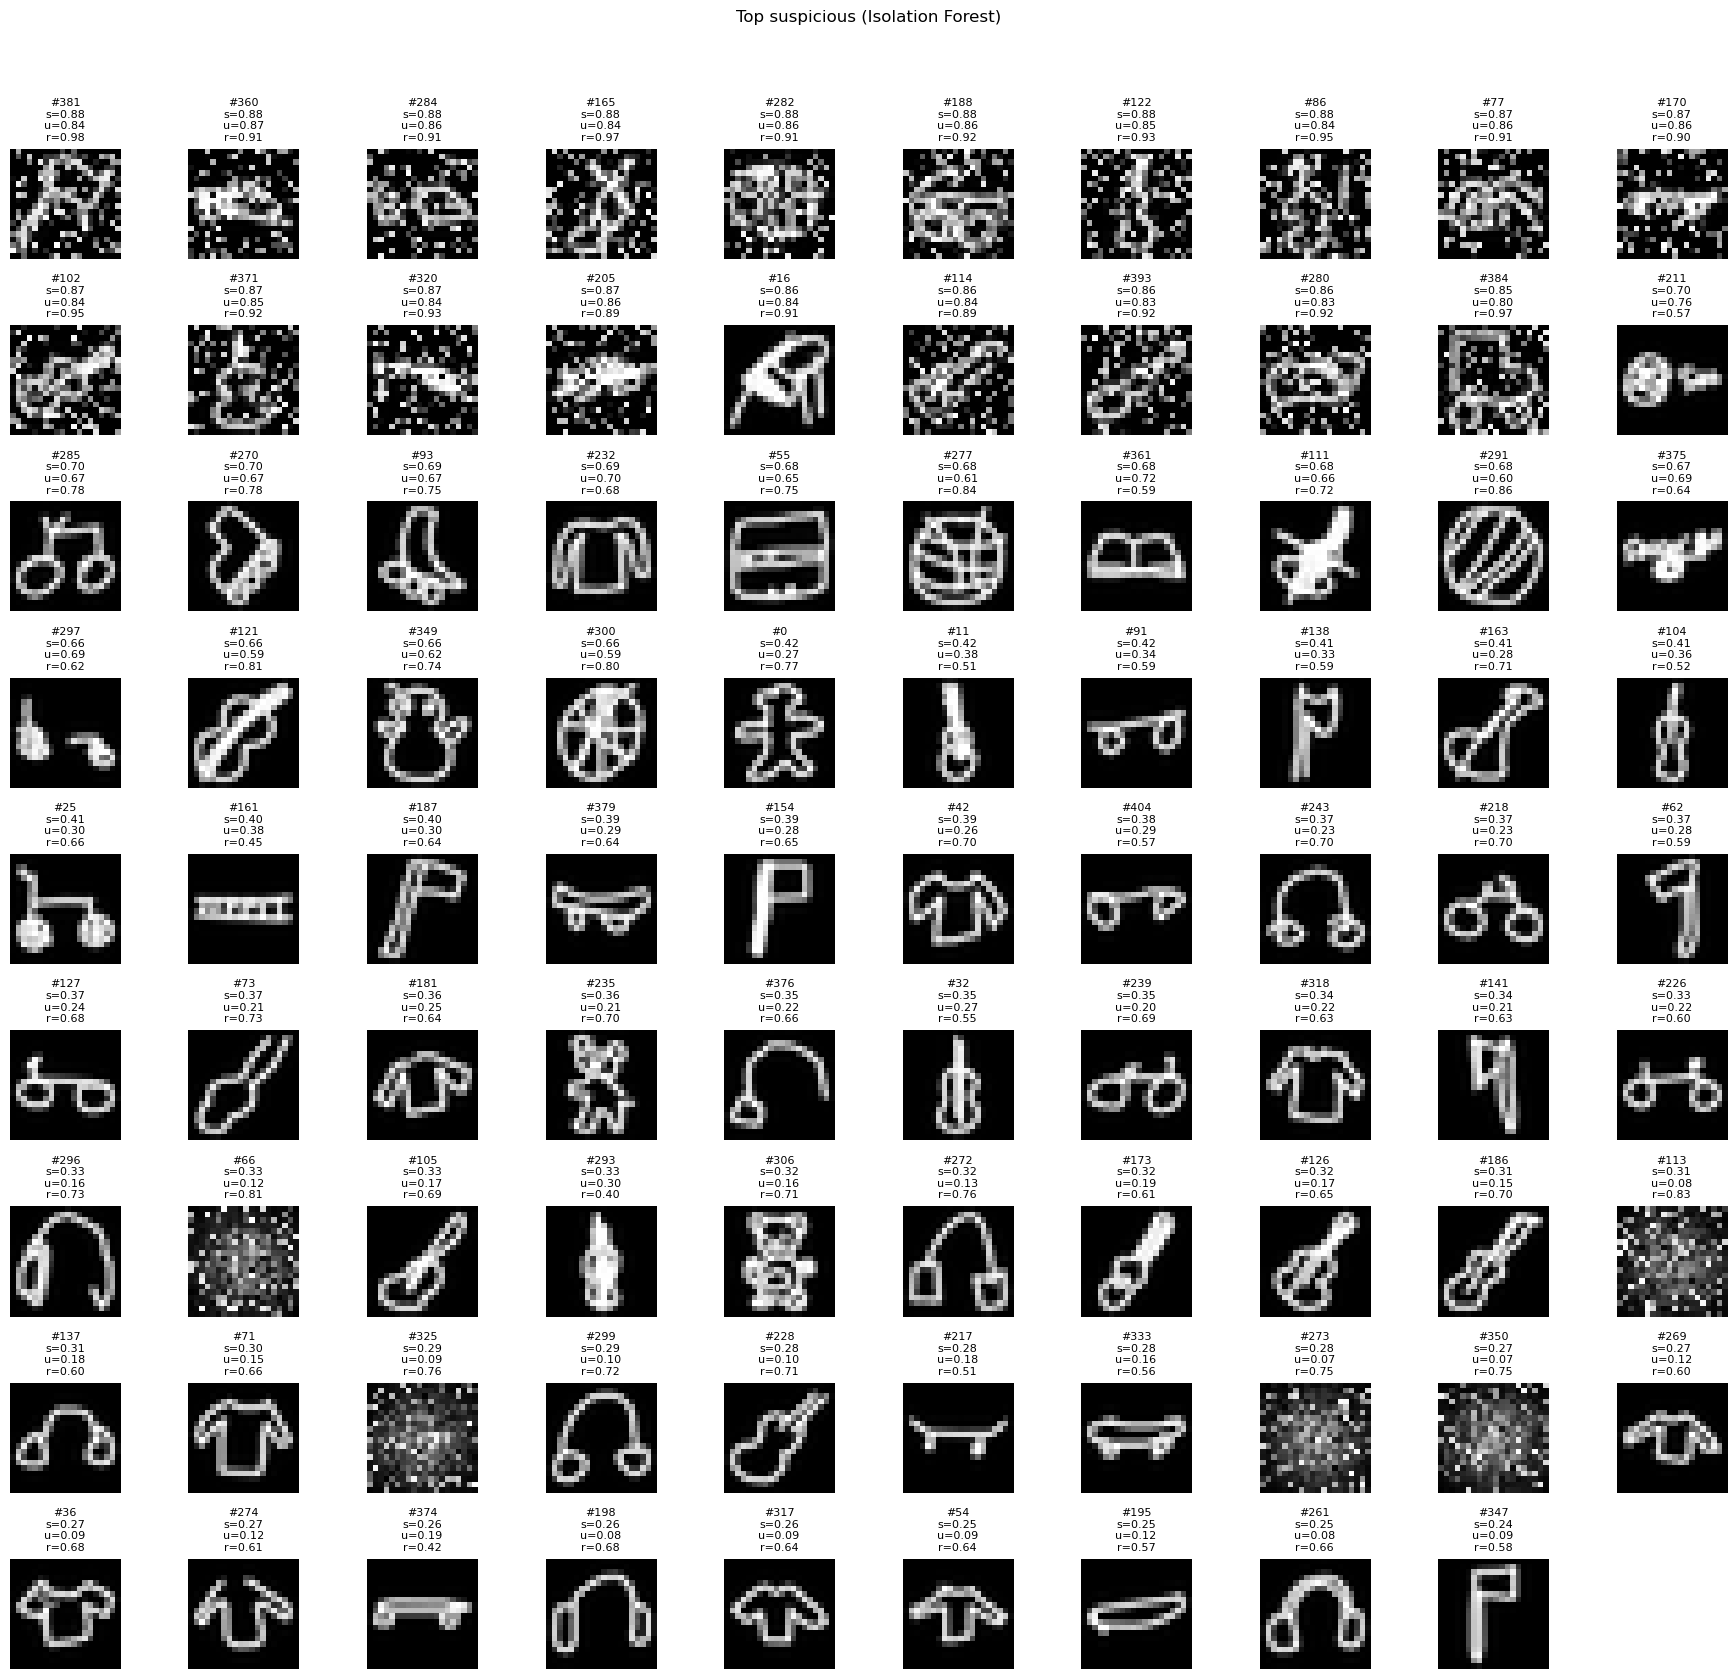

In [ ]:
# --- Visualize top suspicious images ---
top_idx = suspect_idx[np.argsort(score[suspect_idx].ravel())[::-1]]

cols = 10
rows = math.ceil(len(top_idx) / cols)

plt.figure(figsize=(cols * 1.8, rows * 1.8))
for i, k in enumerate(top_idx[:89], 1):  # show top 89
    plt.subplot(rows, cols, i)
    plt.imshow(Xc[k].reshape(20, 20), cmap="gray", vmin=0, vmax=255)
    plt.title(f"#{k}\ns={score[k][0]:.2f}\nu={unc[k]:.2f}\nr={re_n[k]:.2f}", fontsize=8)
    plt.axis("off")
plt.suptitle("Top suspicious (Isolation Forest)", y=1.02)
plt.tight_layout()
plt.show()